# FIT5212: Data analysis for semi-structured data

## Assignment 2

**Student name:** Udit Arora

**Student Id:** 31167799

## Task 1: Recommender system

This task recommends the top 10 items for a user from the given 100 items in the test data set, for all the users. The calculation is done through the interaction of an item and user from training and validation dataset. 

This is accomplished using Alternative Least Squares algorithm applying implicit feedback method. The calculation of AUC-ROC score is done by using Bayesian Personalised Ranking(BPR) by fine tuning the parameters used in the model. From this model we select the top 10 items for each user to recommend.

### Load the data:

In [3]:
import pandas as pd
import numpy as np  

# Read the files
train_data = pd.read_csv("flickr_train_data.csv")
validation_data = pd.read_csv("flickr_validation_data.csv")
test_data = pd.read_csv("flickr_test_data.csv")

# combine together the training and validation data sets
train_validation_data = train_data.append(validation_data)

train_validation_data[1:10]

,user_id,item_id,rating
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,0,8,1
9,0,9,1


### Building the model:

* Starting by creating a sparse matrix, a matrix which consists of either 0 or 1 with 'user' as rows and 'item' as columns. Two matrices are created one for model and other for the recommendation system. 

In [4]:
import scipy.sparse as sparse  

#Sparse matrix for recommendation system
recommendation_sys_matrix = sparse.csr_matrix((train_validation_data['rating'].astype(float), (train_validation_data['user_id'], train_validation_data['item_id'])))

#Sparse matrix for model
model_matrix = sparse.csr_matrix((train_validation_data['rating'].astype(float), (train_validation_data['item_id'], train_validation_data['user_id'])))

* Following models under the implicit methods are taken into consideration 

|     | Model                      |
| ----| ------------------------------ |
| ALS |   Alternating Least Squares  |
| LMF |   Logistic Matrix Factorization |

Both the types of models are built with default parameters and their output files are uploaded to Kaggle and it is found that the NDCG score of LMF recommendations is very low.

So the **ALS** algorithm is finally choosen to build the recommender system.

* To find the best performing ALS model parameters, different sets of parameters are tried and tested to find the best performing model parameters. Only the code for the best performing model is included as multiple models implementation takes a lot of time. 

* Parameters that are finalised for the ALS model are as follow:

|   Parameter  |          Description             |
| ----| ------------------------------ |
| Alpha = 30 |   rate of confidence |
| Factors = 5 |   Latent factors for user and item vectors  |
| Iterations = 30 |   iterations used to fit the data |
| regularization = 0.15 |   constant used in cost function |


**Note:** The code for all the models except for the final best performing one is removed from the code block as it takes a lot of time to run the code.

In [5]:
import implicit

np.random.seed(0)

alpha = 40 #The rate in which we'll increase our confidence in a preference with more interactions.
data = (model_matrix * alpha).astype('double')

#Build the model
model1 = implicit.als.AlternatingLeastSquares(factors=5, regularization=0.15, iterations=30)

#Fitting the model using the input data
model1.fit(data)

100%|██████████| 30/30 [00:01<00:00, 22.81it/s]


In [24]:
# track recommended item and their weight values
recc_item_weight = pd.DataFrame()

#number of users
user_count = train_validation_data['user_id'].nunique()

#number of items
item_count = train_validation_data['item_id'].nunique()

# for all the users
for i in range (0,user_count):
    
    #Track number of recommendations(15)
    recommendations_count = 0
    
    #Get recommendations from the model for the user
    usr_recomm = model1.recommend(i,recommendation_sys_matrix,item_count)
    
    # get test data for the user
    test_data_items = test_data[test_data['user_id']==i]               
    
    # For all recommendations returned by the model for the user
    for rcm in usr_recomm:                                  
        
        # recommended item
        item_no = rcm[0]
        # weight of the recommended item
        item_weight = rcm[1]
        
        # the recommended item is used only if the item is in test data
        if not(test_data_items[test_data_items['item_id'] == item_no].empty):
            
            #increment the recommendation count
            recommendations_count = recommendations_count + 1
            
            #record the recommended item and weight
            recc_item_weight = recc_item_weight.append({'user_id': i, 'item_id': item_no, 'weight': item_weight}, ignore_index=True)
            
            if(recommendations_count == 15):
                break;      

recc_item_weight

,item_id,user_id,weight
0,8552.0,0.0,9.477407
1,3177.0,0.0,9.032385
2,740.0,0.0,7.520896
3,349.0,0.0,7.063329
4,6343.0,0.0,6.883848
...,...,...,...
51985,1873.0,3465.0,5.703547
51986,520.0,3465.0,5.692022
51987,1127.0,3465.0,5.576039
51988,6282.0,3465.0,5.532290


In [25]:
# change the format for output
output_df = recc_item_weight[['user_id','item_id']]

#to csv file
output_df = output_df.astype('int64')
output_df.to_csv('31167799_3.csv',index=False)

## Task 2: Node clustering in graphs



The goal of this task is to cluster the nodes in the network into several categories, and evaluate the performance of different clustering algorithms.

### Load the data:

There are three input files:

|   File  |          Description             |
| ----| ------------------------------ |
| docs.txt |   nodes and their titles |
| adjedges.txt |   First node is the root and successive nodes are its branches   |
| labels.txt  |   node id and its class labels |

In [6]:
#Read the data and store them in dataframes

#read the nodes and their titles data
docs_node_title = pd.DataFrame()

file = open ("docs.txt", encoding = "utf8")

#for each line of the document
for line in file.readlines():
    title = ''
    #split a line
    words = line.split(" ")  
    #title for each node
    for i in range (1,(len(words))):
        title = title + str(words[i]).rstrip('\n') + " "
    #node id
    id_node = line.split(" ")[0]
    #writing to the dataframe
    docs_node_title = docs_node_title.append({'node_id': id_node, 'node_title': title},ignore_index=True)

#close the file
file.closed

#read the classification label data
node_labels = pd.DataFrame()

file = open ("labels.txt", encoding = "utf8")

#for each line of the document
for line in file.readlines():
    #node id
    id_node = line.split(" ")[0]
    group_node = line.split(" ")[1].rstrip('\n')
    #writing to the dataframe
    node_labels = node_labels.append({'node_id': id_node, 'group': group_node},ignore_index=True)

#close the file
file.closed

# read the node and it's branches data (graph data)
#create network graph
import networkx as nx
ntwk_graph = nx.read_adjlist("adjedges.txt")

### Graph Embedding

This task classifies the node based on node or text embedding. In node embedding the classification is based on Node2Vec algorithm from the constructed graph, for the text embedding the classification is done using Word2vec and TfIdf algorithms. 

* **Node Embedding:**

In [17]:
#Node2Vec algorithm
from node2vec import Node2Vec
node_vec = Node2Vec(ntwk_graph, dimensions = 36, walk_length = 10, num_walks = 10)
#embedding the nodes
model = node_vec.fit(window = 10, min_count = 1, batch_words = 4)

#vectorize the 'node_id'
node_id_vectorize = model.wv[node_labels['node_id']].tolist()
#vectorize the 'group'
group_vectorize = node_labels['group'].tolist()


Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [02:51<00:00, 17.19s/it]


* **Text Embedding:**

In [28]:
import gensim
from gensim import models
from gensim.models import Word2Vec
#word2vec algorithm

#structure the data
str_text = [nt.strip().split(' ') for nt in docs_node_title['node_title']]

#word2vec model
word2vec_model = gensim.models.Word2Vec(str_text, min_count = 1 ,workers = 3, window = 3, sg = 1)
#shape of the vector
word2vec_model.wv.vectors.shape

(36724, 100)

The vector generated by Word2Vec model is generated from all the topics so the distinguish factor is not efficient enough so this method is not used.

In [31]:
#tfidf algorithm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# list of title
list_title = docs_node_title['node_title'].tolist()

# list of group
list_group = node_labels['group'].tolist()

#Tokenize topics
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in RegexpTokenizer('[a-zA-Z]+').tokenize(doc)]
    
#vectorizer to remove english stopwords from title
vctrizr = TfidfVectorizer(tokenizer = LemmaTokenizer(),
                         stop_words=stopwords.words('english'),
                         lowercase=True, min_df=5, max_df=0.8,
                         analyzer='word',input='content')

#x label for train data
train_x = vctrizr.fit_transform(list_title)

#y label for train data
train_y = np.asarray(list_group)

/Users/uditarora/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### Models based on node embedding

For node embedding let's build the following models using 10-fold cross validation and find the best performing model for node embedding.

|          Models             |
| ------------------------------ |
|   RandomForestClassifier |
|   LogisticRegression | 
| LinearSVC |

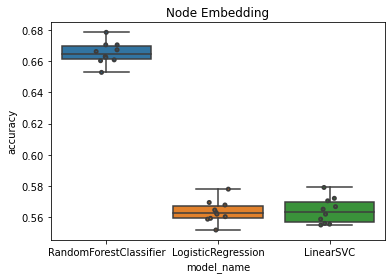

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
#List out all the models
list_models = [
    RandomForestClassifier(),
    LogisticRegression(),
    LinearSVC()    
]

#Number of folds
folds = 10

#store accuracy of each fold for corresponding fold
model_fold_acc = []

#cross validation dataframe
df_crossvalid = pd.DataFrame(index=range(folds * len(list_models)))

#for each model
for model in list_models:
     #name of the model
     modelname = model.__class__.__name__
     #accuracy of the model
     accuracy = cross_val_score(model, node_id_vectorize, group_vectorize, scoring = 'accuracy', cv = folds)
     #for each fold, accuracy pair, add to the list
     for fld_id, acc in enumerate(accuracy):
          model_fold_acc.append((modelname, fld_id, acc))

#add data to the dataframe for model, fold and accuracy
df_crossvalid = pd.DataFrame(model_fold_acc, columns=['model_name', 'fold_idx', 'accuracy'])

#plot the data
sns.boxplot(x='model_name', y='accuracy', data=df_crossvalid).set_title('Node Embedding')
sns.stripplot(x='model_name', y='accuracy', data=df_crossvalid, 
              size=3, jitter=True, linewidth=2)
plt.show()

**Conclusion:** According to the above plot, we can see that RandomForestClassifier has the best accuracy, so for node embedding we use this model.

### Models based on text embedding

For text embedding we build the same models as above and find the best performing model on the basis of 10 fold cross validation.

|          Models             |
| ------------------------------ |
|   RandomForestClassifier |
|   LogisticRegression | 
| LinearSVC |

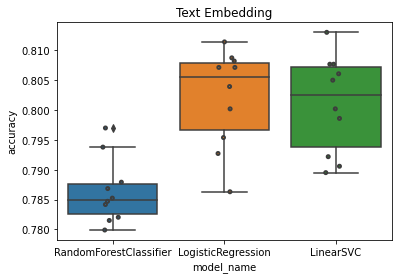

In [41]:
#List out all the models
list_models = [
    RandomForestClassifier(),
    LogisticRegression(),
    LinearSVC()    
]

#Number of folds
folds = 10

#store accuracy of each fold for corresponding fold
model_fold_acc = []

#cross validation dataframe
df_crossvalid = pd.DataFrame(index=range(folds * len(list_models)))

#for each model
for model in list_models:
     #name of the model
     modelname = model.__class__.__name__
     #accuracy of the model
     accuracy = cross_val_score(model, train_x, train_y, scoring = 'accuracy', cv = folds)
     #for each fold, accuracy pair, add to the list
     for fld_id, acc in enumerate(accuracy):
          model_fold_acc.append((modelname, fld_id, acc))

#add data to the dataframe for model, fold and accuracy
df_crossvalid = pd.DataFrame(model_fold_acc, columns=['model_name', 'fold_idx', 'accuracy'])

#plot the data
sns.boxplot(x='model_name', y='accuracy', data=df_crossvalid).set_title('Text Embedding')
sns.stripplot(x='model_name', y='accuracy', data=df_crossvalid, 
              size=3, jitter=True, linewidth=2)
plt.show()            

**Conclusion:** According to the above plot, we can see that the LogisticRegression has the best accuracy, so for text embedding we use this model.

### Finalizing the model

* Create train and test datasets

In [42]:
from sklearn.model_selection import train_test_split

#create train and test datasets
#for node embedding
node_x_train, node_x_test, node_y_train, node_y_test = train_test_split(node_id_vectorize, group_vectorize, test_size = 0.3, random_state = 0)
#splitting test and train for text embedding 
text_x_train, text_x_test, text_y_train, text_y_test = train_test_split(train_x, train_y, test_size = 0.3, random_state = 0)

* RandomForestClassifier for node embedding

In [43]:
#Create classifier
rndm_frst_clsfr = RandomForestClassifier()
#get model name
modelname_rf = rndm_frst_clsfr.__class__.__name__
#fit train data to classifier
rndm_frst_clsfr.fit(node_x_train, node_y_train)

#predict test data
node_y_predict = rndm_frst_clsfr.predict(node_x_test)

* LogisticRegression for text embedding

In [46]:
#Create the classifier
lr = LogisticRegression()
#get model name
modelname_lr = lr.__class__.__name__
#fit train data to classifier
lr.fit(text_x_train, text_y_train)

#predict test data
text_y_predict = lr.predict(text_x_test)

* Calculate the NMI(normalized mutual information) scores:

In [47]:
from sklearn.metrics.cluster import normalized_mutual_info_score
#calculate nmi scores for node embedding
print(modelname_rf)
print(normalized_mutual_info_score(node_y_test, node_y_predict))

#calculate nmi scores for text embedding
print(modelname_lr)
print(normalized_mutual_info_score(text_y_test, text_y_predict))

RandomForestClassifier
0.46570702871978714
LogisticRegression
0.5240933560107274


Based on the above results we have, 

|   Model  |          NMI Score             |
| ----| ------------------------------ |
| Node Embedding, RandomForestClassifier | 0.46570702871978714 |
| Text Embedding, LogisticRegression | 0.5240933560107274 |

Above comparison shows that Text embedding model Logistic Regression has a better NMI score so we can say that this model performs better than the Node embedding model.

## References

* Monash Lecture Notes and Tutorials
* ALS model, https://implicit.readthedocs.io/en/latest/als.html
* LMF model, https://implicit.readthedocs.io/en/latest/lmf.html
* Graphs, https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html
* NMI score, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html
* Train test split, https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
